In [1]:
%load_ext autoreload
%autoreload 2
%aimport RNN_model, RNN_apply_ind

In [ ]:
# If not have run before
import RNN_apply_ind, os, json, argparse

folder_path = r'C:\Users\qilei.zhang\OneDrive - Frontier Airlines\Documents\Data\USconti'
seats_file_name = r'\Schedule_Monthly_Summary_Report_Conti.csv'
perf_file_name = r'\Airline_Performance_Report_Conti.csv'
apply_file_name = '\Schedule_Monthly_Summary_2023Q1234.csv'
# Load parameters from the JSON file.
if not os.path.exists('parameters.json'):
    print("parameters.json does not exist, Find the file and put it in the same folder as this file")
with open('parameters.json', 'r') as f:
    args = argparse.Namespace(**json.load(f))

RNN_apply_ind.main_apply(args, folder_path, seats_file_name, perf_file_name, apply_file_name)

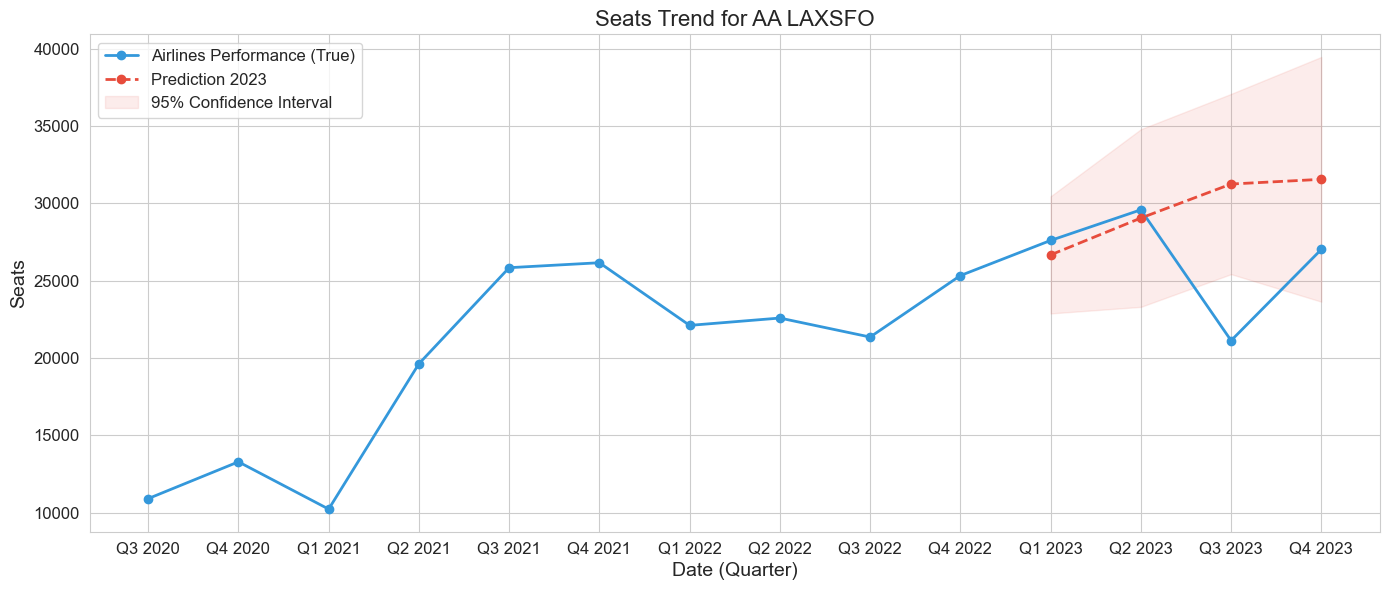

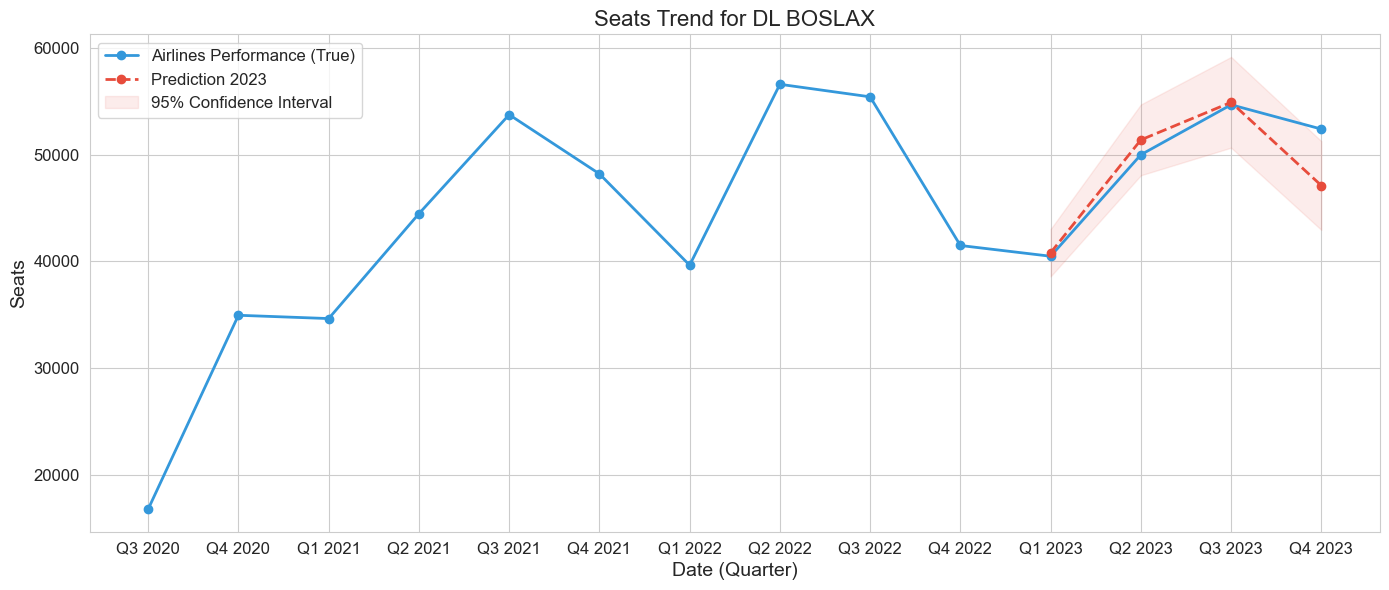

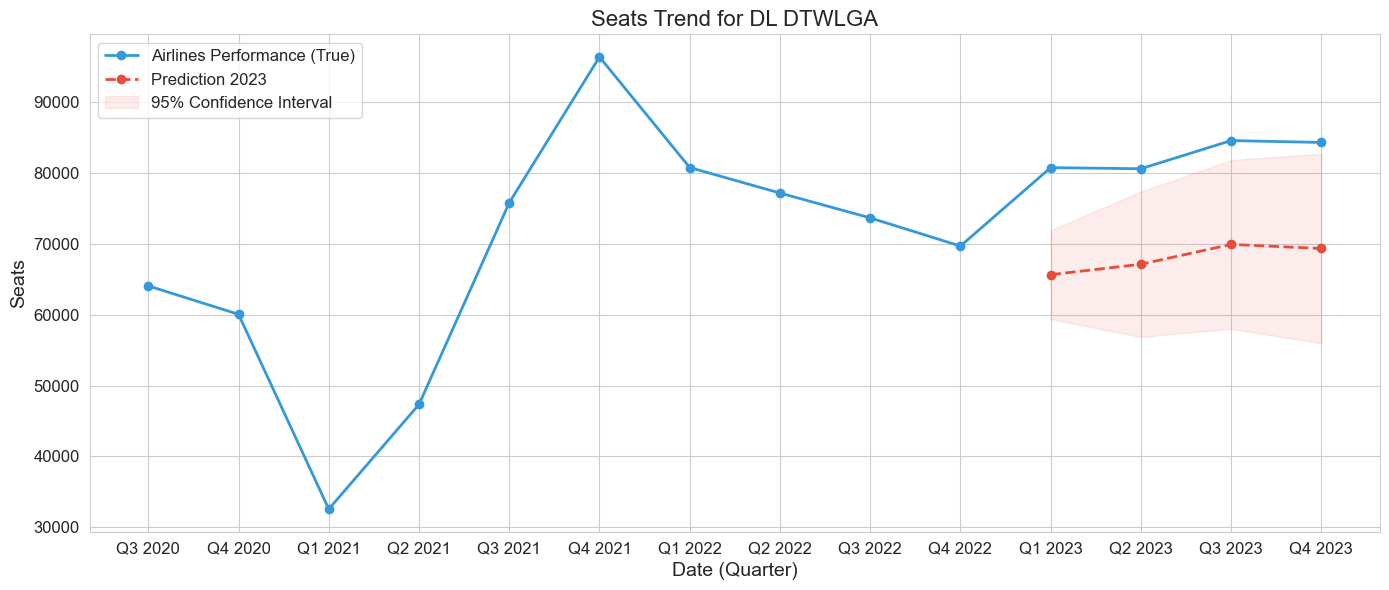

In [1]:
# quick look at the result
import pandas as pd
from RNN_apply_ind import DataAna

apply_filename='./data/applying_data.csv'
ana_df_name = "./results/data_to_ana_apply.csv"
orig_df = pd.read_csv(apply_filename)

ana = DataAna(ana_df_name)
ana.merge_previous_data(orig_df)

while True:
    user_input = input("Enter airline and route, separated by comma, or 'c' to exit: ")
    if user_input.lower() == 'c':
        break
    try:
        airline, route = user_input.split(',')
        airline = airline.strip()  # remove possible leading/trailing whitespaces
        route = route.strip()  # remove possible leading/trailing whitespaces
        ana.plot_prediction(airline, route)
    except ValueError:
        print("Invalid input, please enter the airline and route separated by a comma or 'continue' to proceed.")